In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("covid_19_india.csv")
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [3]:
df["Date"]=pd.to_datetime(df["Date"],format="%d/%m/%y")
df.Date

0      2020-01-30
1      2020-01-31
2      2020-02-01
3      2020-02-02
4      2020-02-03
          ...    
1377   2020-04-27
1378   2020-04-27
1379   2020-04-27
1380   2020-04-27
1381   2020-04-27
Name: Date, Length: 1382, dtype: datetime64[ns]

In [4]:
dates=[]
def getcumondate(df):
    dates.append(df["Date"].unique()[0])
    return np.sum(df["Confirmed"].values)



TotalCasesOnDate=df.groupby("Date").apply(getcumondate)

In [5]:
df_cases=pd.DataFrame({"CasesTillDate(cumulative)":TotalCasesOnDate.values},index=TotalCasesOnDate.index)
df_cases.head()

,CasesTillDate(cumulative)
Date,
2020-01-30,1
2020-01-31,1
2020-02-01,2
2020-02-02,3
2020-02-03,3


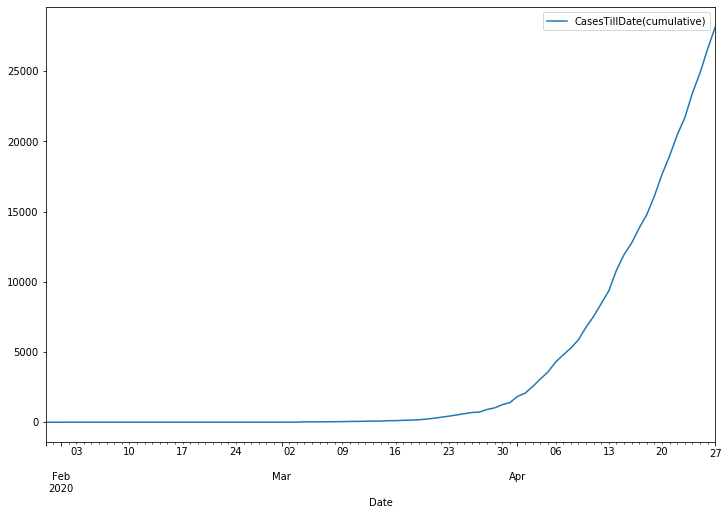

In [6]:
df_cases.plot(figsize=(12,8))

In [7]:
df_cases["TotalCasesShifted"]=df_cases["CasesTillDate(cumulative)"].shift().fillna(0)

In [8]:
df_cases["CasesPerDay"]=df_cases["CasesTillDate(cumulative)"]-df_cases["TotalCasesShifted"]
df_cases.head()

,CasesTillDate(cumulative),TotalCasesShifted,CasesPerDay
Date,,,
2020-01-30,1,0.0,1.0
2020-01-31,1,1.0,0.0
2020-02-01,2,1.0,1.0
2020-02-02,3,2.0,1.0
2020-02-03,3,3.0,0.0


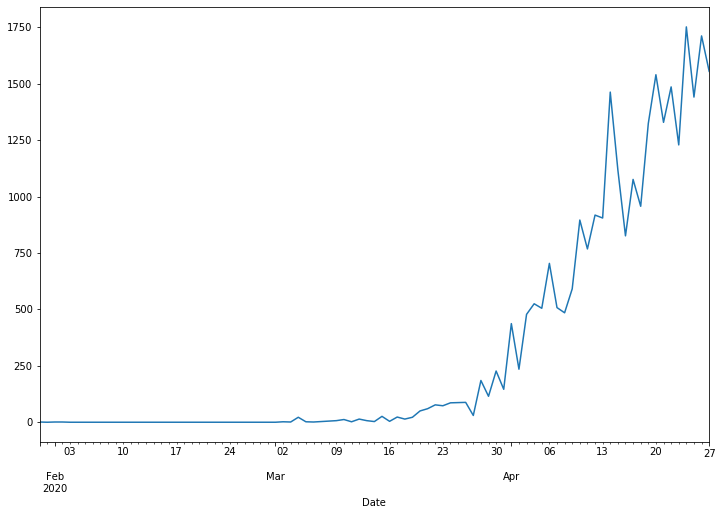

In [9]:
df_cases["CasesPerDay"].plot(figsize=(12,8))

In [10]:
df_cases.index.freq="D"

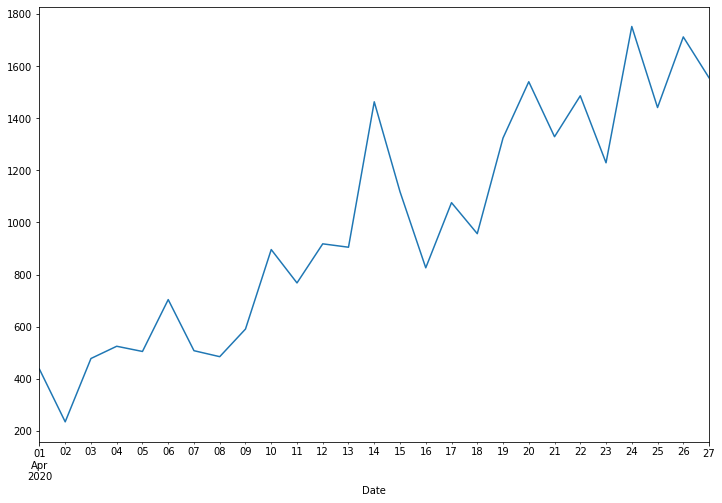

In [11]:
df_cases[df_cases.index >= "2020-04-01"]["CasesPerDay"].plot(figsize=(12,8))

### ETS for complete data

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [13]:
result=seasonal_decompose(df_cases['CasesPerDay'],model='additive')

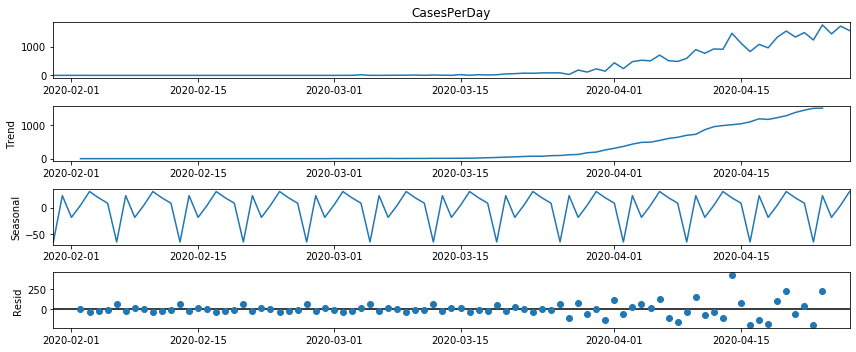

In [14]:
from pylab import rcParams
rcParams['figure.figsize']=12,5
result.plot();

#### Subsetting to April Data

In [15]:
df_cases_april=df_cases[df_cases.index >= "2020-04-01"]
df_cases_april

,CasesTillDate(cumulative),TotalCasesShifted,CasesPerDay
Date,,,
2020-04-01,1834,1397.0,437.0
2020-04-02,2069,1834.0,235.0
2020-04-03,2547,2069.0,478.0
2020-04-04,3072,2547.0,525.0
2020-04-05,3577,3072.0,505.0
2020-04-06,4281,3577.0,704.0
2020-04-07,4789,4281.0,508.0
2020-04-08,5274,4789.0,485.0
2020-04-09,5865,5274.0,591.0


### ETS for April data

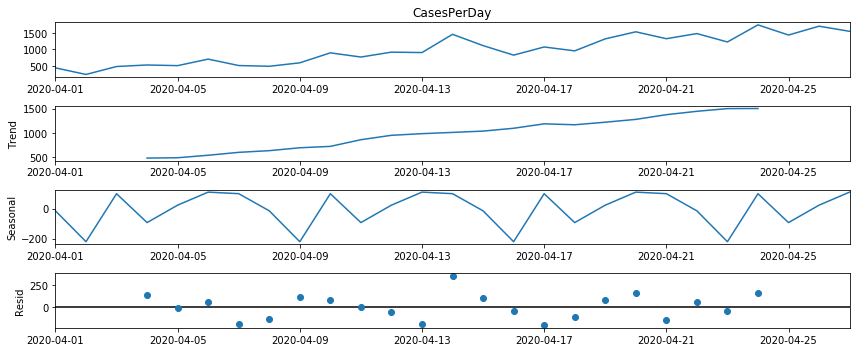

In [16]:
result=seasonal_decompose(df_cases_april['CasesPerDay'],model='additive')
from pylab import rcParams
rcParams['figure.figsize']=12,5
result.plot();

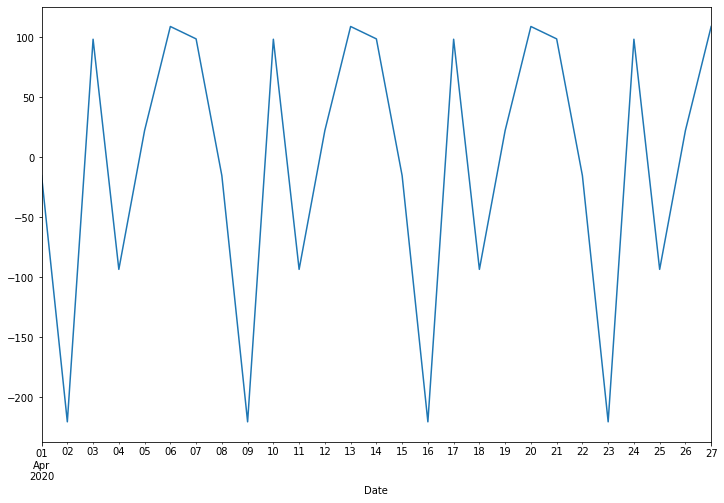

In [17]:
result.seasonal.plot(figsize=(12,8))

In [18]:
### Seasonal periods = 7

### Triple Exponential Smoothening

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
df_cases_april['TES_mul_9']=ExponentialSmoothing(df_cases_april['CasesPerDay'],trend='add',seasonal='mul',seasonal_periods=7).fit().fittedvalues

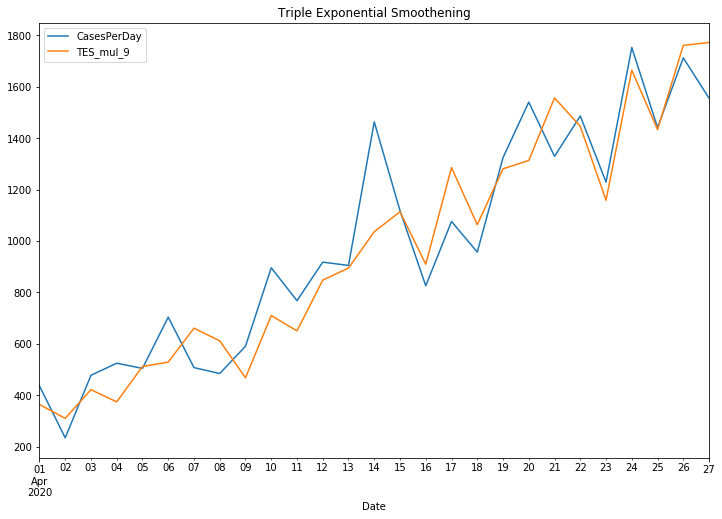

In [21]:
df_cases_april["CasesPerDay"].plot(figsize=(12,8))
df_cases_april["TES_mul_9"].plot()
plt.title("Triple Exponential Smoothening")
plt.legend()

### Evaluating Triple Exponential Smoothening

In [22]:
from statsmodels.tools.eval_measures import rmse

In [23]:
nobs=10
train=df_cases_april[["CasesPerDay"]].iloc[:-nobs,:]
test=df_cases_april["CasesPerDay"][-nobs:]

In [24]:
fitted_model=ExponentialSmoothing(train["CasesPerDay"],
                                 trend='add',
                                 seasonal='mul',
                                 seasonal_periods=7).fit()

In [25]:
test_predictions=fitted_model.forecast(10)

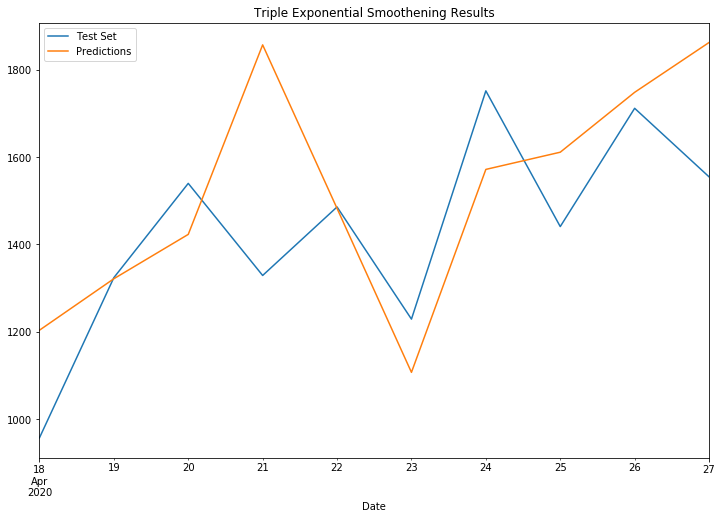

In [26]:
test.plot(figsize=(12,8),label="Test Set")
test_predictions.plot(label="Predictions")
plt.title("Triple Exponential Smoothening Results")
plt.legend()

In [27]:
print("Average New Cases Per Day in April",df_cases_april["CasesPerDay"].mean())
print("Standard Deviation Of New Cases Per Day",df_cases_april["CasesPerDay"].std())

print("RMSE for TES",rmse(test,test_predictions))

Average New Cases Per Day in April 991.2222222222222
Standard Deviation Of New Cases Per Day 443.7785599332287
RMSE for TES 229.35204144400376


### SARIMA

#### Finding differencing Term

In [28]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
 
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [29]:
adf_test(df_cases_april["CasesPerDay"])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.007753
p-value                  0.750426
# lags used              1.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [30]:
adf_test(df_cases_april["CasesPerDay"].diff())

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.962477e+00
p-value                 8.153931e-15
# lags used             0.000000e+00
# observations          2.500000e+01
critical value (1%)    -3.723863e+00
critical value (5%)    -2.986489e+00
critical value (10%)   -2.632800e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [31]:
## d-1

#### Validating whether to add a MA term or AR term or both

In [32]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

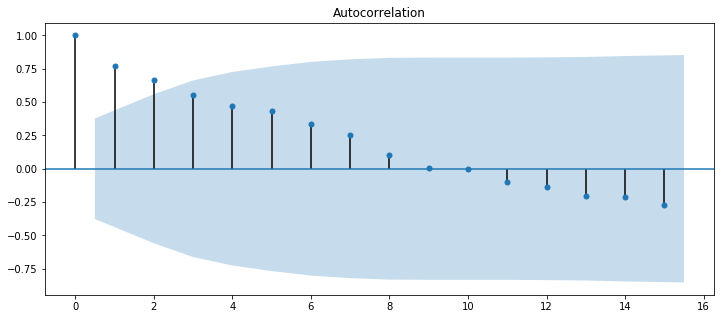

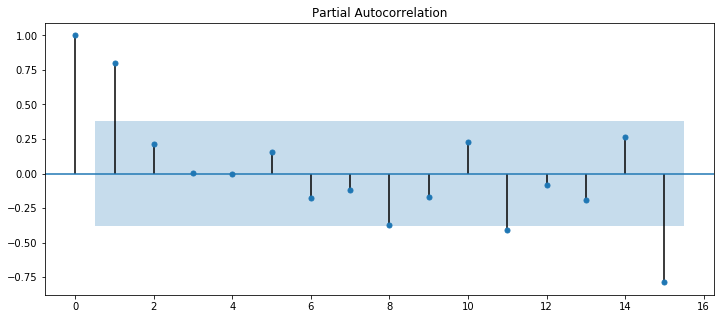

In [33]:
plot_acf(df_cases_april['CasesPerDay']);
plot_pacf(df_cases_april['CasesPerDay']);

In [34]:
## MA - term  (PACF has a steap decrease)
## p- 1 or 2
## PACF has steap drop while ACF has gradual decrease , so we will have AR term

### Checking with GridSearch

In [35]:
from pmdarima import auto_arima

In [36]:
stepwise_fit=auto_arima(df_cases_april['CasesPerDay'],start_p=1,start_q=1,start_P=1,start_Q=1,seasonal=True,m=7,trace=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=354.746, BIC=362.295, Fit time=0.967 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=365.352, BIC=367.868, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=360.192, BIC=365.224, Fit time=0.110 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=351.144, BIC=356.177, Fit time=0.128 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=353.097, BIC=359.387, Fit time=0.354 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=349.186, BIC=352.960, Fit time=0.077 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=350.776, BIC=355.808, Fit time=0.316 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=350.731, BIC=355.764, Fit time=0.163 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=353.188, BIC=359.478, Fit time=0.145 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7);

In [37]:
stepwise_fit=auto_arima(df_cases_april['CasesPerDay'],start_p=1,start_q=1,seasonal=False,trace=True)

Fit ARIMA: order=(1, 1, 1); AIC=350.889, BIC=355.921, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 0); AIC=365.352, BIC=367.868, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=358.293, BIC=362.068, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1); AIC=349.283, BIC=353.057, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 2); AIC=350.845, BIC=355.878, Fit time=0.082 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.389 seconds


In [38]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   26
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -171.642
Method:                       css-mle   S.D. of innovations            167.214
Date:                Wed, 29 Apr 2020   AIC                            349.283
Time:                        14:57:00   BIC                            353.057
Sample:                             1   HQIC                           350.370
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.7900      4.132     12.535      0.000      43.692      59.888
ma.L1.D.y     -1.0000      0.101     -9.930      0.000      -1.197      -0.803
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
### auto_arima isn't working fine

In [40]:
## Chosing ARIMA (1, 1, 1) , seasonal_order= 0, 0, 0, 7

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
nobs=10
train=df_cases_april[["CasesPerDay"]].iloc[:-nobs,:]
test=df_cases_april["CasesPerDay"][-nobs:]

In [43]:
model = SARIMAX(train['CasesPerDay'],order=(1,1,1),seasonal_order=(2,1,2,7))
results=model.fit()

In [44]:
start=train.shape[0]
end=start+len(test)-1

predictions=results.predict(start=start, end=end, dynamic=False ,typ='levels').rename('SARIMA Predictions')


Text(0.5, 1.0, 'SARIMA Model')

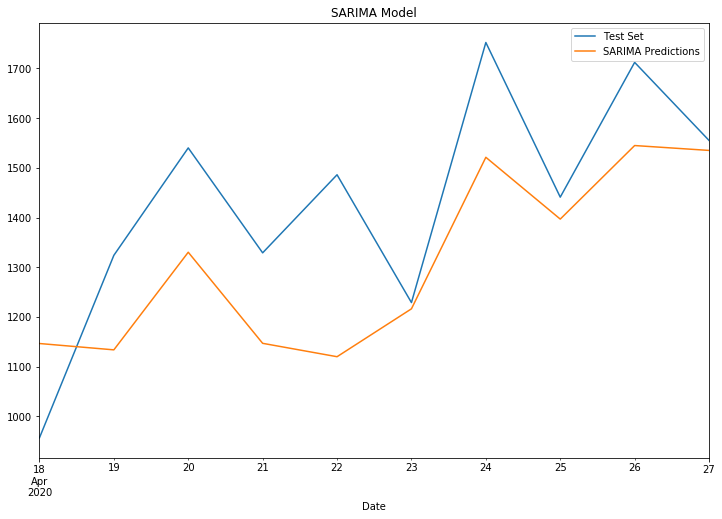

In [45]:
test.plot(figsize=(12,8),label="Test Set")
predictions.plot(legend=True)
plt.legend()
plt.title("SARIMA Model")

In [46]:
rmse(test,predictions)

191.53301492749654

### ForeCasting SARIMA Model

In [47]:
model = SARIMAX(df_cases_april['CasesPerDay'],order=(1,1,1),seasonal_order=(2,1,2,7))
results=model.fit()

In [48]:
start=len(df_cases_april)
end=start+14
forecasts=results.predict(start=start, end=end, dynamic=False ,typ='levels').rename('SARIMA Forecast')

Text(0.5, 1.0, 'SARIMA Model Forecast')

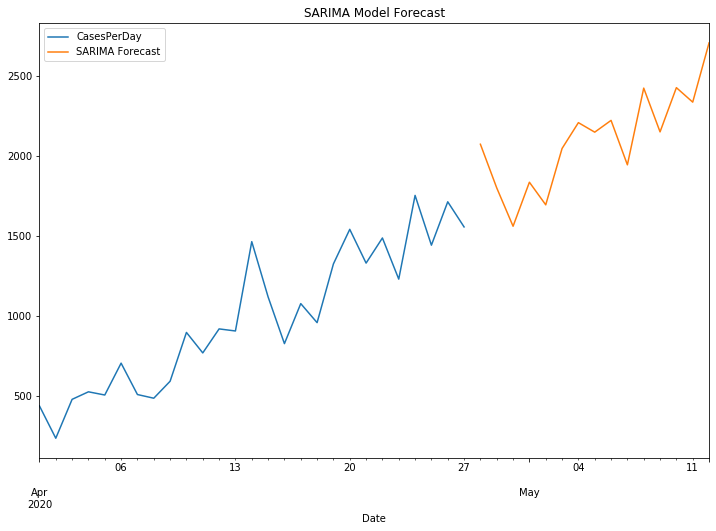

In [49]:
df_cases_april["CasesPerDay"].plot(figsize=(12,8))
forecasts.plot()
plt.legend()
plt.title("SARIMA Model Forecast")

In [50]:
forecasts

2020-04-28    2071.561236
2020-04-29    1798.727542
2020-04-30    1559.272809
2020-05-01    1834.369141
2020-05-02    1693.042666
2020-05-03    2045.033368
2020-05-04    2206.498646
2020-05-05    2147.063658
2020-05-06    2220.553265
2020-05-07    1942.978081
2020-05-08    2422.215034
2020-05-09    2148.786439
2020-05-10    2425.127697
2020-05-11    2334.611679
2020-05-12    2704.740948
Freq: D, Name: SARIMA Forecast, dtype: float64

### ARIMA 

In [51]:
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults

In [52]:
nobs=7
train=df_cases_april["CasesPerDay"][:-nobs]
test=df_cases_april["CasesPerDay"][-nobs:]

In [53]:
model = ARIMA(train,order=(1,1,1))
results = model.fit()

In [54]:
start=len(train)
end=start+len(test)-1
predictions=results.predict(start=start, end=end, dynamic=False, typ='levels').rename("ARIMA MODEl")

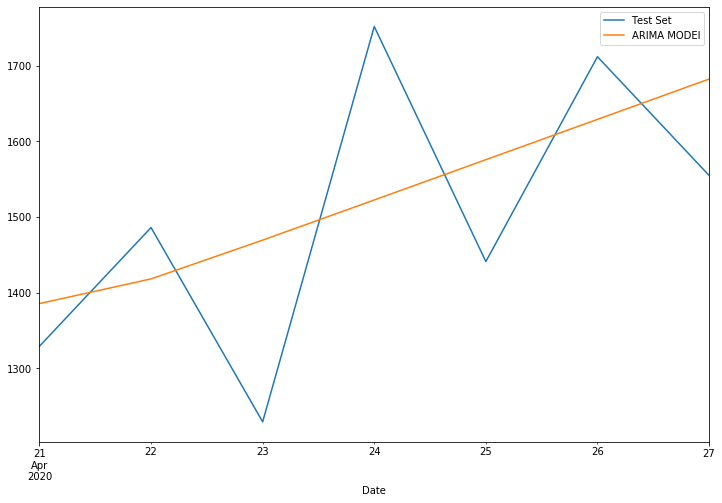

In [55]:
test.plot(figsize=(12,8),label="Test Set")
predictions.plot()
plt.legend()

In [56]:
rmse(test,predictions)

150.96249852733186

### Forecasting using ARIMA

In [57]:
model = ARIMA(df_cases_april["CasesPerDay"],order=(1,1,1))
results = model.fit()

In [58]:
start=len(df_cases_april["CasesPerDay"])
end=start+14
predictions=results.predict(start=start, end=end, dynamic=False, typ='levels').rename("ARIMA MODEl Forecasts")

Text(0.5, 1.0, 'ARIMA Model Forecast')

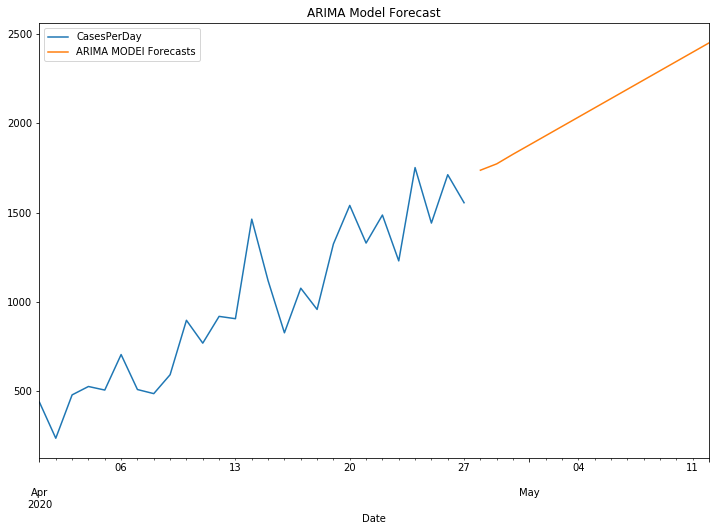

In [59]:
df_cases_april["CasesPerDay"].plot(figsize=(12,8))
predictions.plot()
plt.legend()
plt.title("ARIMA Model Forecast")

In [60]:
predictions

2020-04-28    1737.284126
2020-04-29    1772.988694
2020-04-30    1827.040767
2020-05-01    1878.796264
2020-05-02    1930.839226
2020-05-03    1982.846206
2020-05-04    2034.857689
2020-05-05    2086.868609
2020-05-06    2138.879600
2020-05-07    2190.890582
2020-05-08    2242.901564
2020-05-09    2294.912547
2020-05-10    2346.923530
2020-05-11    2398.934512
2020-05-12    2450.945495
Freq: D, Name: ARIMA MODEl Forecasts, dtype: float64

### Viewing 28th april number of cases

In [61]:
april_data=pd.read_csv("28thapril.csv")

In [62]:
corrected_dates=[]
for i in april_data["Date"]:
    corrected_dates.append(i.replace("2020","20"))

april_data["Date"]=corrected_dates

april_data["Date"]=pd.to_datetime(april_data["Date"],format="%d/%m/%y")

In [63]:
april_data.Date

0      2020-01-30
1      2020-01-31
2      2020-02-01
3      2020-02-02
4      2020-02-03
          ...    
1409   2020-04-28
1410   2020-04-28
1411   2020-04-28
1412   2020-04-28
1413   2020-04-28
Name: Date, Length: 1414, dtype: datetime64[ns]

In [64]:
dates=[]
def getcumondate(df):
    dates.append(df["Date"].unique()[0])
    return np.sum(df["Confirmed"].values)



TotalCasesOnDate=april_data.groupby("Date").apply(getcumondate)

In [65]:
april_data_cases=pd.DataFrame({"CasesTillDate(cumulative)":TotalCasesOnDate.values},index=TotalCasesOnDate.index)

In [66]:
april_data_cases["TotalCasesShifted"]=april_data_cases["CasesTillDate(cumulative)"].shift().fillna(0)

In [67]:
april_data_cases["CasesPerDay"]=april_data_cases["CasesTillDate(cumulative)"]-april_data_cases["TotalCasesShifted"]

In [68]:
april_data_cases

,CasesTillDate(cumulative),TotalCasesShifted,CasesPerDay
Date,,,
2020-01-30,1,0.0,1.0
2020-01-31,1,1.0,0.0
2020-02-01,2,1.0,1.0
2020-02-02,3,2.0,1.0
2020-02-03,3,3.0,0.0
...,...,...,...
2020-04-24,23452,21700.0,1752.0
2020-04-25,24893,23452.0,1441.0
2020-04-26,26605,24893.0,1712.0


In [69]:
predictions

2020-04-28    1737.284126
2020-04-29    1772.988694
2020-04-30    1827.040767
2020-05-01    1878.796264
2020-05-02    1930.839226
2020-05-03    1982.846206
2020-05-04    2034.857689
2020-05-05    2086.868609
2020-05-06    2138.879600
2020-05-07    2190.890582
2020-05-08    2242.901564
2020-05-09    2294.912547
2020-05-10    2346.923530
2020-05-11    2398.934512
2020-05-12    2450.945495
Freq: D, Name: ARIMA MODEl Forecasts, dtype: float64

### VAR Model between Number of tests and covid cases

In [70]:
df_tests=pd.read_csv("ICMRTestingDetails.csv")
df_tests.head()

,SNo,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases
0,1,13/03/20 18:00,6500.0,5900.0,78.0
1,2,18/03/20 18:00,13125.0,12235.0,150.0
2,3,19/03/20 18:00,14175.0,13285.0,182.0
3,4,20/03/20 18:00,15404.0,14514.0,236.0
4,5,21/03/20 18:00,16911.0,16021.0,315.0


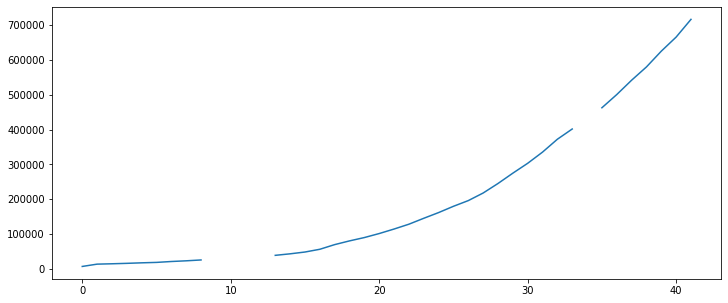

In [71]:
df_tests["TotalSamplesTested"].plot()

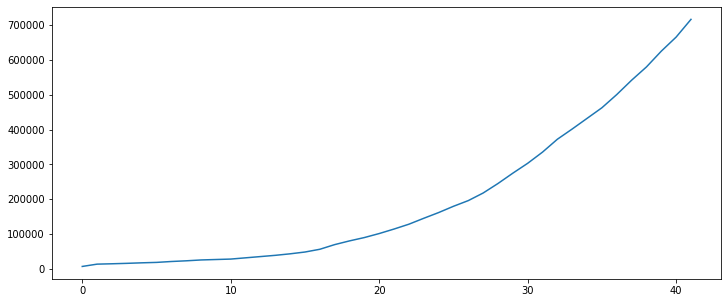

In [72]:
df_tests["TotalSamplesTested"]=df_tests["TotalSamplesTested"].interpolate()
df_tests["TotalSamplesTested"].plot()

In [73]:
df_tests["TotalSamplesTestedShifted"]=df_tests["TotalSamplesTested"].shift().fillna(0)

In [74]:
df_tests.head()

,SNo,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,TotalSamplesTestedShifted
0,1,13/03/20 18:00,6500.0,5900.0,78.0,0.0
1,2,18/03/20 18:00,13125.0,12235.0,150.0,6500.0
2,3,19/03/20 18:00,14175.0,13285.0,182.0,13125.0
3,4,20/03/20 18:00,15404.0,14514.0,236.0,14175.0
4,5,21/03/20 18:00,16911.0,16021.0,315.0,15404.0


In [75]:
df_tests["SamplesTestedPerDay"]=df_tests["TotalSamplesTested"]-df_tests["TotalSamplesTestedShifted"]
df_tests.head()

,SNo,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,TotalSamplesTestedShifted,SamplesTestedPerDay
0,1,13/03/20 18:00,6500.0,5900.0,78.0,0.0,6500.0
1,2,18/03/20 18:00,13125.0,12235.0,150.0,6500.0,6625.0
2,3,19/03/20 18:00,14175.0,13285.0,182.0,13125.0,1050.0
3,4,20/03/20 18:00,15404.0,14514.0,236.0,14175.0,1229.0
4,5,21/03/20 18:00,16911.0,16021.0,315.0,15404.0,1507.0


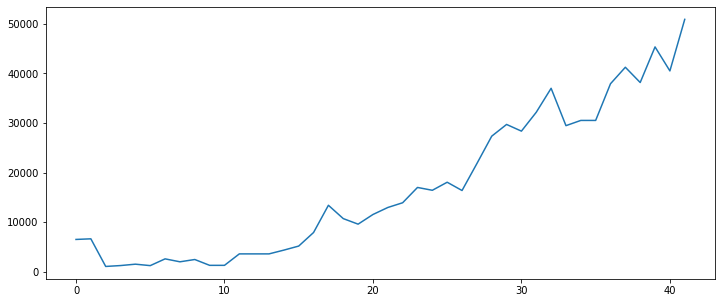

In [76]:
df_tests["SamplesTestedPerDay"].plot()

In [77]:
dates=[]
for i in df_tests["DateTime"]:
    dates.append(i.split(" ")[0])


df_tests["DateTime"]=pd.to_datetime(dates,format="%d/%m/%y")

In [78]:
df_tests_april=df_tests[df_tests["DateTime"]>="2020-04-01"][["DateTime","SamplesTestedPerDay"]]
df_tests_april.set_index("DateTime",inplace=True)
df_tests_april.index.name="Date"
df_tests_april.head()

,SamplesTestedPerDay
Date,
2020-04-01,5163.0
2020-04-02,7900.0
2020-04-03,13394.0
2020-04-04,10705.0
2020-04-05,9584.0


In [79]:
df_cases_april_subset=df_cases_april[["CasesPerDay"]]
df_cases_april_subset.head()

,CasesPerDay
Date,
2020-04-01,437.0
2020-04-02,235.0
2020-04-03,478.0
2020-04-04,525.0
2020-04-05,505.0


In [80]:
df_cases_tests_april=df_tests_april.join(df_cases_april_subset)
df_cases_tests_april.head()

,SamplesTestedPerDay,CasesPerDay
Date,,
2020-04-01,5163.0,437.0
2020-04-02,7900.0,235.0
2020-04-03,13394.0,478.0
2020-04-04,10705.0,525.0
2020-04-05,9584.0,505.0


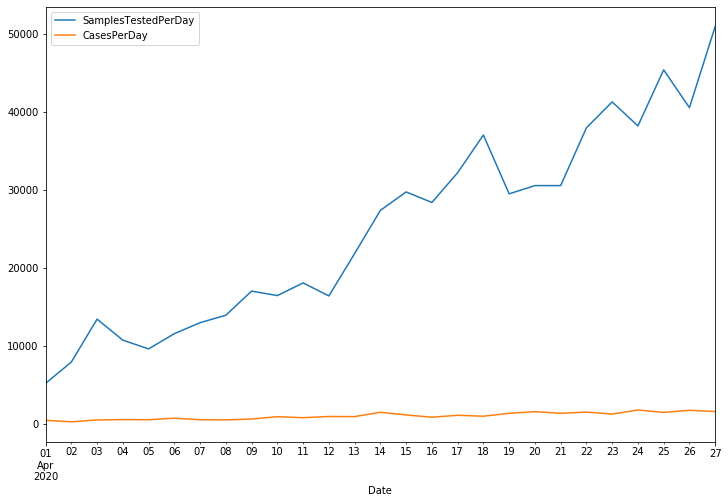

In [81]:
df_cases_tests_april.plot(figsize=(12,8))

In [82]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
 
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [83]:
adf_test(df_cases_tests_april["SamplesTestedPerDay"])

Augmented Dickey-Fuller Test: 
ADF test statistic       0.297442
p-value                  0.977227
# lags used              6.000000
# observations          20.000000
critical value (1%)     -3.809209
critical value (5%)     -3.021645
critical value (10%)    -2.650713
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [84]:
adf_test(df_cases_tests_april.diff().dropna()["SamplesTestedPerDay"])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.051823
p-value                  0.030330
# lags used              5.000000
# observations          20.000000
critical value (1%)     -3.809209
critical value (5%)     -3.021645
critical value (10%)    -2.650713
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [85]:
adf_test(df_cases_tests_april.diff().dropna()["CasesPerDay"])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.962477e+00
p-value                 8.153931e-15
# lags used             0.000000e+00
# observations          2.500000e+01
critical value (1%)    -3.723863e+00
critical value (5%)    -2.986489e+00
critical value (10%)   -2.632800e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [86]:
df_cases_tests_april_transformed=df_cases_tests_april.diff().dropna()

In [87]:
df_cases_tests_april_transformed.index.freq="D"
df_cases_tests_april_transformed.head()

,SamplesTestedPerDay,CasesPerDay
Date,,
2020-04-02,2737.0,-202.0
2020-04-03,5494.0,243.0
2020-04-04,-2689.0,47.0
2020-04-05,-1121.0,-20.0
2020-04-06,1950.0,199.0


In [88]:
nobs=7
train, test = df_cases_tests_april_transformed[0:-nobs], df_cases_tests_april_transformed[-nobs:]

In [89]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [90]:
for i in [1,2,3,4,5]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  27.59513820137342
BIC:  27.891928787338806

Order = 2
AIC:  27.39886539515047
BIC:  27.888990891654128

Order = 3
AIC:  27.69179853545669
BIC:  28.3678136674165

Order = 4
AIC:  26.967186697855574
BIC:  27.816846939178227

Order = 5
AIC:  25.590978643956998
BIC:  26.59521159049526



In [91]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Apr, 2020
Time:                     14:57:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    26.5952
Nobs:                     14.0000    HQIC:                   25.4980
Log likelihood:          -196.867    FPE:                3.89702e+11
AIC:                      25.5910    Det(Omega_mle):     1.22211e+11
--------------------------------------------------------------------
Results for equation SamplesTestedPerDay
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                        677.152640       782.800733            0.865           0.387
L1.SamplesTestedPerDay        -0.486347         0.242012           -2.010           0.044
L1.CasesPe

In [92]:
z = results.forecast(y=train.values[-5:], steps=7)

In [93]:
idx = pd.date_range('2020-04-21', periods=7, freq='D')
df_forecast = pd.DataFrame(z, index=idx, columns=['SamplesTestedPerDay 1D','CasesPerDay 1D'])
df_forecast

,SamplesTestedPerDay 1D,CasesPerDay 1D
2020-04-21,6838.169354,608.564263
2020-04-22,3895.591545,-466.189028
2020-04-23,2802.913796,-650.203609
2020-04-24,6562.464610,229.349344
2020-04-25,2452.847174,-67.520587
2020-04-26,-12218.291467,354.757149
2020-04-27,-3703.177710,535.745019


In [94]:
df_forecast["SamplesTestedPerDay"]= df_cases_tests_april['SamplesTestedPerDay'].iloc[-nobs-1] + df_forecast['SamplesTestedPerDay 1D'].cumsum()

In [95]:
df_forecast["CasesPerDay"]=df_cases_tests_april['CasesPerDay'].iloc[-nobs-1] + df_forecast['CasesPerDay 1D'].cumsum()

In [96]:
df_forecast

,SamplesTestedPerDay 1D,CasesPerDay 1D,SamplesTestedPerDay,CasesPerDay
2020-04-21,6838.169354,608.564263,37355.669354,2148.564263
2020-04-22,3895.591545,-466.189028,41251.260900,1682.375234
2020-04-23,2802.913796,-650.203609,44054.174696,1032.171625
2020-04-24,6562.464610,229.349344,50616.639306,1261.520969
2020-04-25,2452.847174,-67.520587,53069.486480,1194.000381
2020-04-26,-12218.291467,354.757149,40851.195013,1548.757531
2020-04-27,-3703.177710,535.745019,37148.017303,2084.502550


In [97]:
df_cases_tests_april.iloc[-nobs:]

,SamplesTestedPerDay,CasesPerDay
Date,,
2020-04-21,30517.5,1329.0
2020-04-22,37921.0,1486.0
2020-04-23,41247.0,1229.0
2020-04-24,38168.0,1752.0
2020-04-25,45352.0,1441.0
2020-04-26,40510.0,1712.0
2020-04-27,50914.0,1555.0


Text(0.5, 1.0, 'New Cases Per Day')

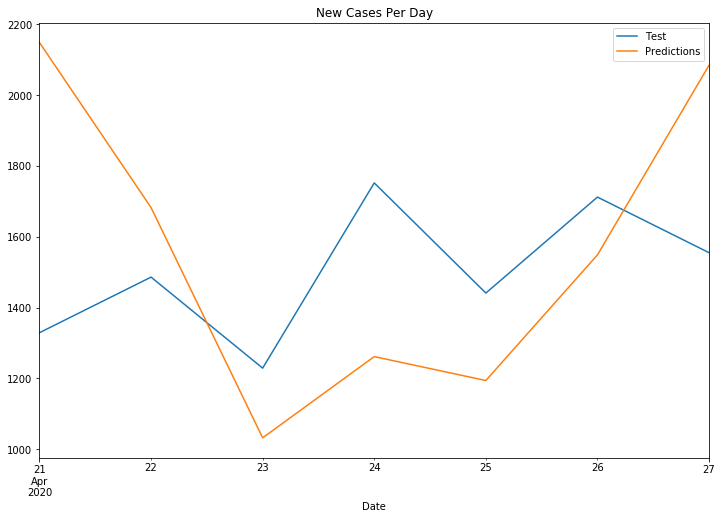

In [98]:
df_cases_tests_april.iloc[-nobs:]["CasesPerDay"].plot(figsize=(12,8),label="Test")
df_forecast["CasesPerDay"].plot(label="Predictions")
plt.legend()
plt.title("New Cases Per Day")

Text(0.5, 1.0, 'Samples Tested Per Day')

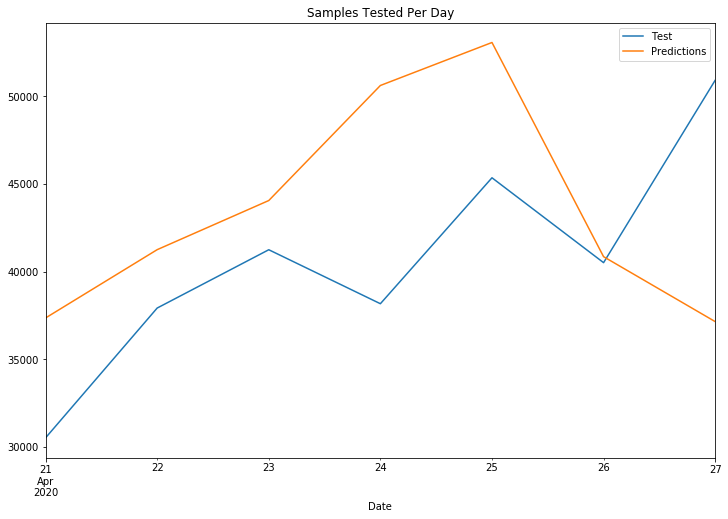

In [99]:
df_cases_tests_april.iloc[-nobs:]["SamplesTestedPerDay"].plot(figsize=(12,8),label="Test")
df_forecast["SamplesTestedPerDay"].plot(label="Predictions")
plt.legend()
plt.title("Samples Tested Per Day")

In [100]:
from statsmodels.tools.eval_measures import rmse

In [101]:
rmse(df_cases_tests_april.iloc[-nobs:]["CasesPerDay"],df_forecast["CasesPerDay"])

440.3877785859326